In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import neighbors
from sklearn import metrics

# Data loading / cleaning

In [2]:
ncaa = pd.read_csv('ncaa_player_stats.csv')
ncaa.columns

Index(['Unnamed: 0', 'active_from', 'active_to', 'birth_date', 'college',
       'height', 'name', 'position', 'url', 'weight', 'NBA__3ptapg',
       'NBA__3ptpct', 'NBA__3ptpg', 'NBA_efgpct', 'NBA_fg%', 'NBA_fg_per_game',
       'NBA_fga_per_game', 'NBA_ft%', 'NBA_ft_per_g', 'NBA_fta_p_g',
       'NBA_g_played', 'NBA_ppg', 'NCAA__3ptapg', 'NCAA__3ptpct',
       'NCAA__3ptpg', 'NCAA_efgpct', 'NCAA_fgapg', 'NCAA_fgpct', 'NCAA_fgpg',
       'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg'],
      dtype='object')

In [3]:
#load NCAA data
ncaa = pd.read_csv('ncaa_player_stats.csv')

#drop rows without ncaa data
ncaa.dropna(subset=['NCAA_games'], inplace=True)

#select relevant rows
ncaa = ncaa[['college', 'height', 'name', 'position', 'weight', 
'NCAA__3ptapg', 'NCAA__3ptpct', 'NCAA__3ptpg', 'NCAA_fgapg',
'NCAA_fgpct', 'NCAA_fgpg', 'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']]

In [4]:
#load NBA data
nba = pd.read_csv('nba_player_stats.csv')

#only past 20 years
nba = nba.loc[nba['Year']>=2004,:]

In [5]:
rookies = pd.DataFrame(columns=['name', 'PER', 'rookie_year','age'])

for i in range(len(nba['Player'].unique())):
    p = nba['Player'].unique()[i]
    player = nba.loc[nba['Player']==p,:]
    
    player.reset_index(inplace=True)
    first_year = player.loc[0,'Year']
    
    rookies.loc[i,'name'] = player.loc[0,'Player']
    rookies.loc[i,'PER'] = player.loc[player['Year']==first_year,'PER'].mean()
    rookies.loc[i,'rookie_year'] = int(first_year)
    rookies.loc[i,'age'] = int(player.loc[0,'Age'])

In [6]:
data = pd.merge(rookies, ncaa)

In [7]:
#manage null values - assuming these columns mean no data present = no points scored
data.loc[data['NCAA__3ptapg'].isnull(),'NCAA__3ptapg']=0
data.loc[data['NCAA_ftapg'].isnull(),'NCAA_ftapg']=0
data.loc[data['NCAA_fgapg'].isnull(),'NCAA_fgapg']=0
data.loc[data['NCAA__3ptpg'].isnull(),'NCAA__3ptpg']=0
data.loc[data['NCAA_ft'].isnull(),'NCAA_ft']=0

#2 null values still in PER column - drop
data.dropna(subset=['PER'], inplace=True)

#column with missing values - to be aware of
for c in data.columns:
    if sum(data[c].isna())>0:
        print('Columns with na values left:')
        print(c)
        print(sum(data[c].isna()))
        
data.reset_index(inplace=True)

Columns with na values left:
NCAA__3ptpct
80


In [8]:
#convert height to inches
for i in range(len(data)):
    l = data['height'][i].split('-')
    data.loc[i, 'height']=int(l[0])*12+int(l[1])

In [9]:
#create dummy columns for position
positions = pd.get_dummies(data['position'],dtype=int)
#data = data.merge(positions, right_index=True, left_index=True)

#create 'all' columns for similar positions
data['position_C']=positions['C']+positions['C-F']+positions['F-C']
data['position_F']=positions['F']+positions['C-F']+positions['F-C']+positions['F-G']+positions['G-F']
data['position_G']=positions['G']+positions['F-G']+positions['G-F']

In [10]:
def outliers(column):
    
    low_iq = data[column].quantile(.25)
    high_iq = data[column].quantile(.75)
    
    diff = high_iq - low_iq
    
    low_limit = low_iq - 1.5*diff
    upper_limit = high_iq + 1.5*diff
    
    outliers = data[data[column]<low_limit]
    
    outliers = pd.concat([outliers, data[data[column]>upper_limit]], axis=0)
    
    return outliers.index

In [11]:
numeric = data.drop(['name', 'college', 'position', 'index','rookie_year'],axis=1)

#for dealing with outliers: if less than 5% of data (58 rows) I will drop outlying rows
for c in numeric.columns[:-3]:
    #print('number of outliers in',c,'col:', len(outliers(c)))
    if len(outliers(c)) < 58:
        data.drop(outliers(c),axis=0,inplace=True)
    else:
        print(c,len(outliers(c)))

age 115
NCAA__3ptpct 130


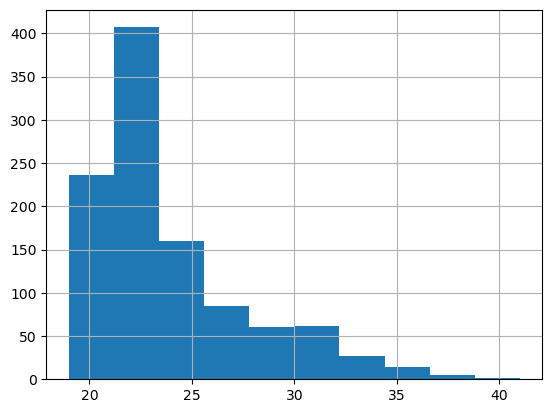

In [12]:
#for the two remaining cols with outliers: age is not normally distributed
data['age'].hist()

numeric = numeric.drop('age',axis=1)
#and 3 point percent has a lot of NAN values - not all positions shoot 3s.  So will adjust analysis based on position

# Initial data exploration / general models

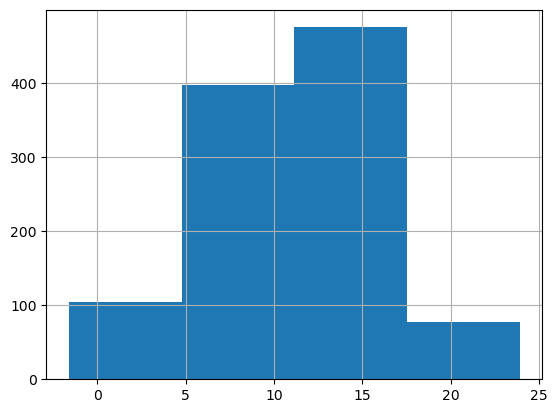

In [13]:
data['PER'].hist(bins=4)
data['PER_cat'] = pd.cut(data['PER'],bins=4, labels = [1,2,3,4])

NCAA_games     -0.111625
position_G     -0.102530
NCAA__3ptpct   -0.085377
NCAA__3ptapg   -0.081840
NCAA__3ptpg    -0.081161
NCAA_ft        -0.067831
NCAA_fgapg      0.058915
height          0.091375
position_C      0.092424
position_F      0.098521
weight          0.109199
NCAA_ppg        0.115967
NCAA_ftpg       0.123784
NCAA_fgpg       0.139150
NCAA_ftapg      0.147748
NCAA_fgpct      0.196530
Name: PER, dtype: float64

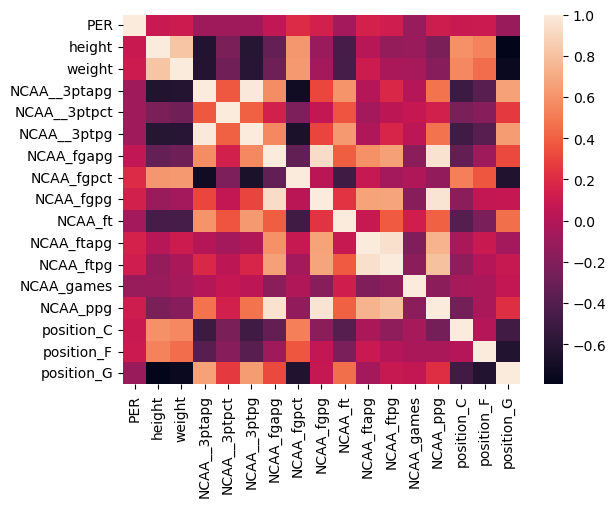

In [14]:
#potential relationships with target variable 

c = numeric.corr()
sns.heatmap(c)
c['PER'].sort_values()[:-1]

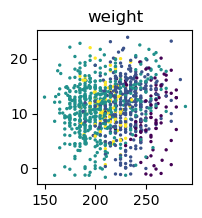

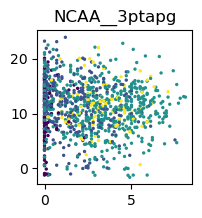

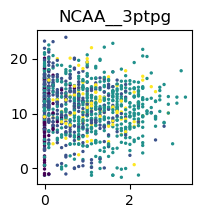

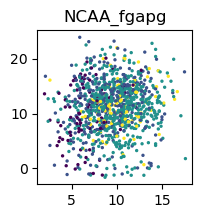

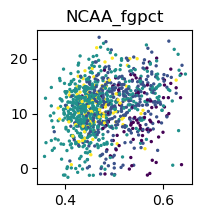

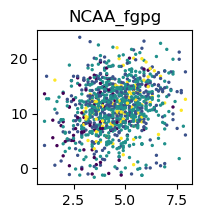

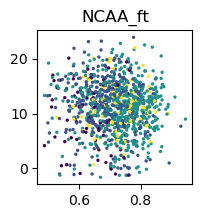

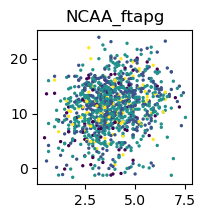

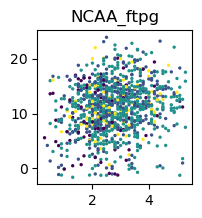

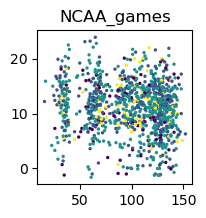

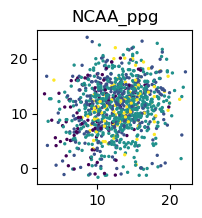

In [18]:
#color denotes position

predictor_vars = numeric.columns[2:].drop('NCAA__3ptpct')
color = data['position_C']+2*data['position_F']+3*data['position_G']

for c in predictor_vars[:-3]:
    plt.figure(figsize=(2,2))
    plt.scatter(data[c],data['PER'], c=color, s=2)
    plt.title(c)
    plt.show()

In [36]:
to_scale = numeric.columns[1:-3]

scale = preprocessing.StandardScaler().fit(data[to_scale])
scaled = data.copy()
scaled[to_scale] = scale.transform(data[to_scale])

scaled

,index,name,PER,rookie_year,age,college,height,position,weight,NCAA__3ptapg,...,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg,position_C,position_F,position_G,PER_cat
1,1,Malik Allen,10.5,2004,25,Villanova University,1.010555,F-C,1.498443,-1.219593,...,-0.906137,-0.238329,-0.669767,-0.684396,0.862880,-1.086880,1,1,0,2
2,2,Ray Allen,21.7,2004,28,University of Connecticut,-0.428621,G,-0.454907,1.280867,...,1.956251,0.782362,-0.280274,0.030332,0.086858,1.771404,0,0,1,4
3,3,Rafer Alston,13.7,2004,27,"California State University, Fresno",-1.292127,G,-1.783185,1.673096,...,-0.588094,0.524115,-1.448755,-1.297020,-1.942736,-0.492583,0,0,1,3
4,4,Derek Anderson,15.1,2004,29,"Ohio State University, University of Kentucky",-0.428621,G,-0.884644,0.006123,...,-0.349562,1.102096,0.109220,0.438748,0.027164,-0.096385,0,0,1,3
6,6,Shandon Anderson,10.1,2004,30,University of Georgia,-0.140786,F-G,-0.337706,-0.533192,...,0.286525,-1.000773,0.187119,-0.173876,0.594257,0.045114,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1167,Okaro White,7.5,2017,24,Florida State University,0.434885,F,-0.493974,-0.484163,...,-0.906137,1.028311,-0.202375,0.132436,1.221043,-0.747282,0,1,0,2
1166,1168,Isaiah Whitehead,7.5,2017,21,Seton Hall University,-0.716457,G,-0.142371,1.624067,...,0.445546,0.511817,0.576613,0.745060,-1.256255,0.865809,0,0,1,2
1167,1169,Troy Williams,9.766667,2017,22,Indiana University,0.147049,F,0.052964,-0.631249,...,-0.270051,-0.127652,-0.202375,-0.173876,0.027164,-0.407684,0,1,0,2
1168,1170,Kyle Wiltjer,6.7,2017,24,Gonzaga University,1.010555,F,0.912438,0.741552,...,0.127503,1.335748,-1.215059,-0.888604,1.459819,0.073414,0,1,0,2


r^2: 0.12032199218157702


C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


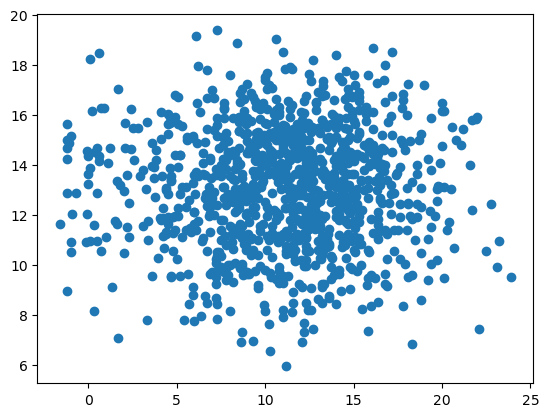

In [34]:
pca = PCA()
pca.fit(scaled[predictor_vars])
pca_x = pca.fit_transform(scaled[predictor_vars])

reg = LinearRegression()
reg.fit(pca_x, scaled['PER'])
print('r^2:',reg.score(pca_x,scaled['PER']))

plt.scatter(scaled['PER'],reg.predict(scaled[predictor_vars]))
#this is not a strong model.  Ideally the plot should be closer to a straight line.

In [41]:
train, test = train_test_split(data, random_state=47)
cart = tree.DecisionTreeClassifier()
cart.fit(train[predictor_vars[:-3]],train['PER_cat'])

#accuracy:
print('accuracy:',sum(test['PER_cat'] == cart.predict(test[predictor_vars[:-3]]))/len(test['PER_cat']))

accuracy: 0.37358490566037733


In [72]:
train, test = train_test_split(data, random_state=47)

pca = PCA()
pca.fit(train[predictor_vars])
pca_train = pca.fit_transform(train[predictor_vars])
pca_test = pca.fit_transform(test[predictor_vars])

r2_scores = []
for i in range(1,100):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    knn.fit(pca_train, train['PER'])
    r2_scores.append(metrics.r2_score(test['PER'],knn.predict(pca_test)))
    
print(max(r2_scores))


0.04248066487854085


0.05782348773000656
105


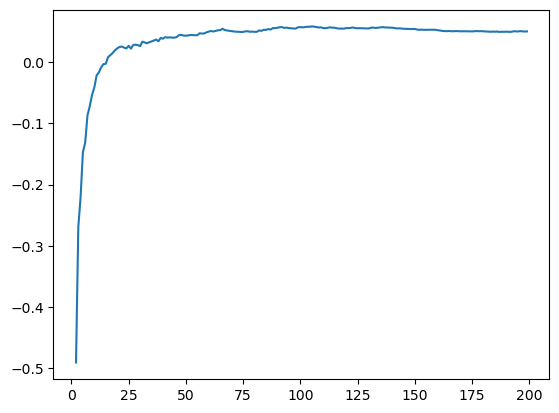

In [71]:
train, test = train_test_split(data, random_state=47)

r2 = []
max_r2 = 0
best_k = 0
for i in range(2,200):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i,weights='distance')
    knn.fit(train[predictor_vars], train['PER'])
    score = metrics.r2_score(test['PER'],knn.predict(test[predictor_vars]))
    r2.append(score)
    if score > max_r2:
        max_r2 = score
        best_k = i
    
plt.plot(range(2,200),r2)
print(max_r2)
print(best_k)

# Explore correlations / create models by position specifically

In [ ]:
#explore correlations by position specifically
pos_corr = numeric.drop(['position_G','position_F','position_C'],axis=1).columns

In [ ]:
guards = data[data['position_G']==1]

g = guards[pos_corr].corr()
sns.heatmap(g)
print('correlations with PER variable for Guards:\n',g['PER'].sort_values()[:-1])

In [ ]:
for c in predictor_vars[:-3]:
    plt.figure(figsize=(2,2))
    plt.scatter(guards[c],guards['PER'], s=2)
    plt.title(c)
    plt.show()

In [ ]:
#relationship between NCAA free throw / field goal for guards is very clear - these are also highly correlated
#perform PCA with variables

In [ ]:
pca = PCA(n_components=4)
pca.fit(guards[['NCAA_games', 'NCAA_ft','NCAA_fgapg', 'NCAA_ftapg','NCAA_ftpg', 'NCAA_fgpg', 'NCAA_ppg', 'NCAA_fgpct']])

In [ ]:
dim1 = pca.fit_transform(guards[predictor_vars[:-3]])[:,0]
dim2 = pca.fit_transform(guards[predictor_vars[:-3]])[:,1]
dim3 = pca.fit_transform(guards[predictor_vars[:-3]])[:,2]

In [ ]:
train, test = train_test_split(guards, random_state=47)
cart = tree.DecisionTreeClassifier()
cart.fit(train[predictor_vars[:-3]],train['PER_cat'])

plt.figure(figsize=(30,10))
tree.plot_tree(cart,fontsize=10,max_depth=3)
plt.show()

#accuracy:
sum(test['PER_cat'] == cart.predict(test[predictor_vars[:-3]]))

# Forwards analysis

In [ ]:
forwards = data[data['position_F']==1]

f = forwards[pos_corr].corr()
sns.heatmap(f)
print('correlations with PER variable for Forwards:\n',f['PER'].sort_values()[:-1])

In [ ]:
centers = data[data['position_C']==1]

c = centers[pos_corr].corr()
sns.heatmap(c)
print('correlations with PER variable for Centers:\n',c['PER'].sort_values()[:-1])

In [ ]:
reg = LinearRegression()
reg.fit(guards[guard_predictors], guards['PER'])
print(reg.score(guards[guard_predictors],guards['PER']))
reg.coef_

In [ ]:
predictor_vars = pos_corr.drop(['PER','NCAA__3ptpct'])
#predictor_vars.drop(['PER','NCAA__3ptpct'])
predictor_vars

In [ ]:
#this is not a great analysis.

scaled[['NCAA__3ptpct','position_G', 'position_C','position_F', 'weight', 'NCAA_fgpct', 'NCAA_ftapg']]

In [ ]:
guards = scaled.loc[scaled['position_G']==1,:]

In [ ]:
plt.scatter(dim3, dim2)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(dim1, dim2, guards['PER'])
plt.show()

#plt.scatter(dim1, dim2)

# Identifying odds of rookie being top talent - top 25%

In [ ]:
top = data[data['PER']>data['PER'].quantile(.75)]

In [ ]:
top.describe().loc['mean',:]

In [ ]:
bottom = data[data['PER']<data['PER'].quantile(.75)]

In [ ]:
bottom.describe().loc['mean',:]